# Derivatives

(C) Pietro Vischia, 2025
pietro.vischia@cern.ch

We have seen during the lecture that computer derivatives are crucial, particularly for things like machine learning.

In this notebook we will compare the main ways of computing derivatives, and will come up with a basic---but perfectly working---implementation of automatic differentiation.


<img src="autodiff_edit.png" alt="drawing" width="50%"/>
Image from Güneş Baydin et al, [JMLR 18 (2018) 1--43](https://jmlr.org/papers/v18/17-468.html)


We first import a few useful libraries.

- `math` provides, among other things, trigonometrical functions. In this tutorial, we are interested in `sin` and `cos`.
- `matplotlib` is a plotting library, we will use it to make plots

In [32]:
import math
import matplotlib.pyplot as plt

Let's begin by defining a simple function of one variable

In [33]:
def f_math(x):
    return 2 + 3*math.sin(x) + x**3


And let's plot it

In [34]:
x = np.linspace(-10,10, 10)
plt.plot(x, f_math(x))

TypeError: only length-1 arrays can be converted to Python scalars

Why does it fail? It turns out that the simple `math` library doesn't natively support vector operations.
To make it work, we need to loop on the elements of `x`

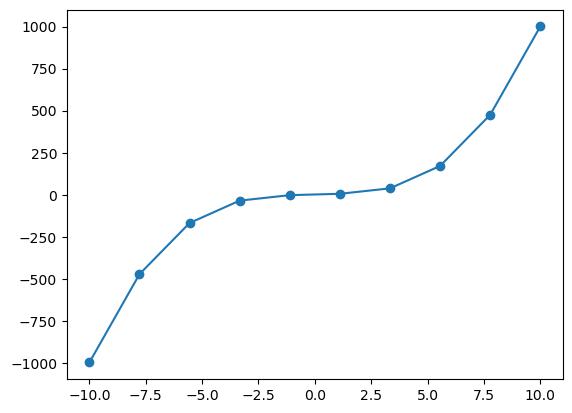

In [35]:
plt.plot(x, [f_math(xi) for xi in x])
plt.scatter(x, [f_math(xi) for xi in x])

However, who wants to do that?

`numpy` is a library that provides more control on vector operations than the one provided by the basic python arrays.

Let's import the library, redefine and re-plot the function.

In [39]:
import numpy as np

In [38]:
def f(x):
    return 2 + 3*np.sin(x) + x*x*x

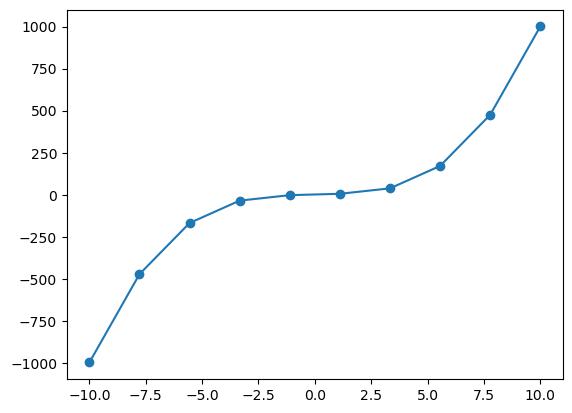

In [40]:
plt.plot(x, f(x))
plt.scatter(x, f(x))

We will also define our own plotting function, to have points and lines at the same time

In [49]:
def myplot(x, y, label=''):
    plt.plot(x, y, label=label)
    plt.scatter(x, y)

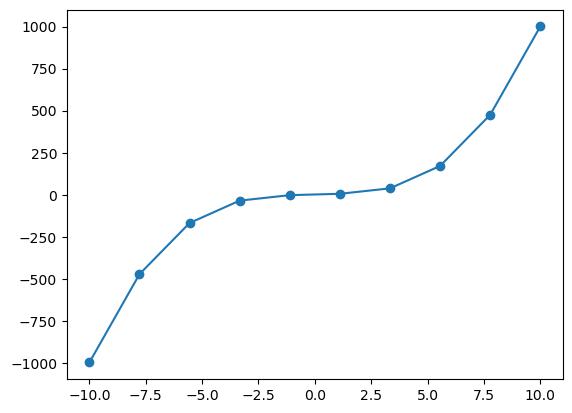

In [50]:
myplot(x, f(x))

Now we can compute and plot the analytical derivative of `f`

In [51]:
def anal_deriv(x):
    return 3*np.cos(x)+ 3*x**2
    

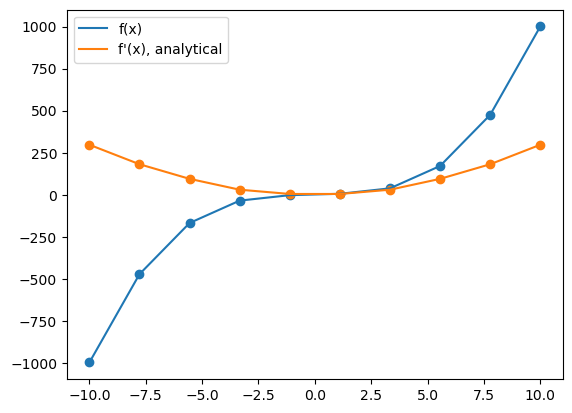

In [52]:
myplot(x, f(x), label="f(x)")
myplot(x, anal_deriv(x), label="f'(x), analytical")
plt.legend()

We can plot the function to an arbitrary level of precision (up to machine precision), by evaluating the functions in more points


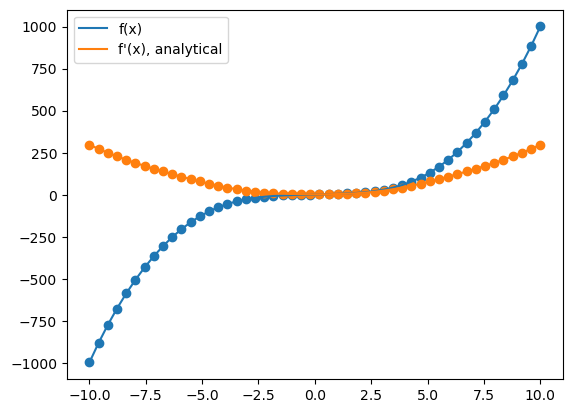

In [57]:
x = np.linspace(-10,10, 50)

myplot(x, f(x), label="f(x)")
myplot(x, anal_deriv(x), label="f'(x), analytical")
plt.legend()

Let's go back to our 10 points

In [189]:
x = np.linspace(-10,10, 10)


Symbolic differentiation is based on software that interprets the expression obtaining its symbolic form. Any additional operation, like for instance taking the derivative of the function, is performed by acting on the symbolic expression.

We will use the package `sympy` to translate our function into a symbolic expression, and to then calculate the symbolic derivative

In [59]:
import sympy

In [60]:
symbolic_x = sympy.symbols('x')
symbolic_func = f(symbolic_x)
symbolic_func

sym_y = sympy.lambdify(symbolic_x,symbolic_func)(x)


TypeError: loop of ufunc does not support argument 0 of type Symbol which has no callable sin method

What is happening? `sympy` does not recognize `numpy`-specific expressions, so we will have to revert back to using our basic expression based on the `math`library

In [61]:
import sympy

symbolic_x = sympy.symbols('x')
symbolic_func = f_math(symbolic_x)
symbolic_func

sym_y = sympy.lambdify(symbolic_x,symbolic_func)(x)


TypeError: Cannot convert expression to float

However, not even that is working: `sympy` seems to be able to access `math` functions, but having represented `x` in symbolic form prevents it to be passed to `math.sin`, which expects a float.

As it often happens, the solution is to use `sympy`'s own definition of `sin`.

In [70]:
def f_sympy(x):
    return 2 + 3*sympy.sin(x)+ x**3
x_symb = sympy.symbols('x')
f_symb = f_sympy(x_symb)
f_symb

x**3 + 3*sin(x) + 2

Note that `sympy` reorders the terms according to its own rules.

We can now let the software calculate the symbolic derivative very easily

In [71]:
symb_deriv = f_symb.diff(x_symb)
symb_deriv

3*x**2 + 3*cos(x)

Now let's plot the symbolic derivative.
In order to obtain an array of numbers (which is what `matplotlib` expects), we will evaluate the function on our `x` by converting the symbolic expression into a python `lambda` function

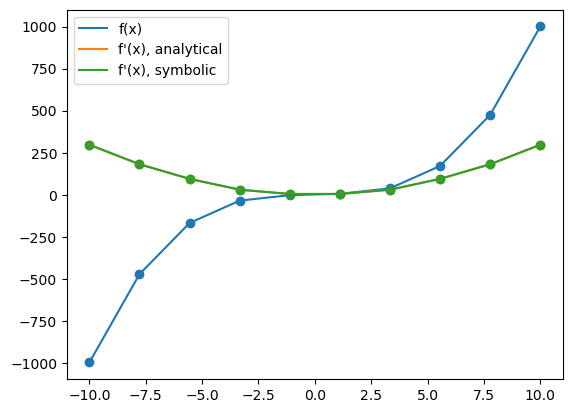

In [74]:
myplot(x, f(x), label="f(x)")
myplot(x, anal_deriv(x), label="f'(x), analytical")
myplot(x, sympy.lambdify(x_symb,symb_deriv)(x), label="f'(x), symbolic")
plt.legend()

The symbolic derivative always matches with the exact derivative!

This is always true, no matter whether you evaluate it in more points or less points:

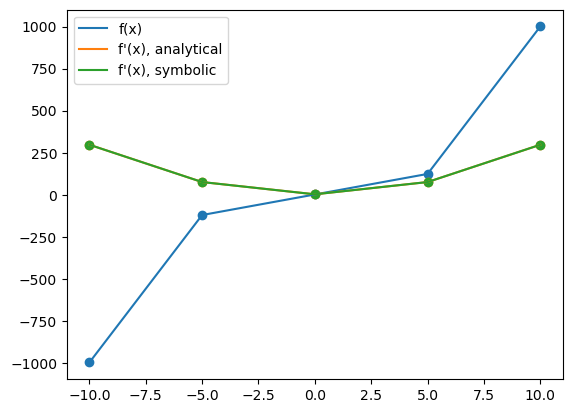

In [96]:
x_fewpoints = np.linspace(-10,10, 5)
myplot(x_fewpoints, f(x_fewpoints), label="f(x)")
myplot(x_fewpoints, anal_deriv(x_fewpoints), label="f'(x), analytical")
myplot(x_fewpoints, sympy.lambdify(x_symb,symb_deriv)(x_fewpoints), label="f'(x), symbolic")
plt.legend()

However, symbolic differentiation applied to long or complicated expressions tends to result in huge derivative expressions that are slow to evaluate 

In [279]:
def complicated_f(x):
    #return 2 + sympy.atan(x)*sympy.sin(x)+sympy.cos(x+3)*sympy.log(x)**3
    return 64*x*(1-x)*((1-2*x)**2)*(1-8*x+8*x**2)**2
x_symb = sympy.symbols('x')
f_comp_symb = complicated_f(x_symb)
f_comp_symb


64*x*(1 - 2*x)**2*(1 - x)*(8*x**2 - 8*x + 1)**2

In [280]:
comp_symb_deriv = f_comp_symb.diff(x_symb)
comp_symb_deriv

64*x*(1 - 2*x)**2*(1 - x)*(32*x - 16)*(8*x**2 - 8*x + 1) - 64*x*(1 - 2*x)**2*(8*x**2 - 8*x + 1)**2 + 64*x*(1 - x)*(8*x - 4)*(8*x**2 - 8*x + 1)**2 + 64*(1 - 2*x)**2*(1 - x)*(8*x**2 - 8*x + 1)**2

Let's now calculate numerical derivatives, using the finite differences method.

Exercise: you could also modify the formula to use the central finite differences, that provides a somehow better precision.

In [101]:
def num_deriv(x, epsilon):
    return (f(x+epsilon)-f(x))/epsilon

We can now compare the derivatives we obtained. We will not plot the function `f(x)`, so that we can zoom better on the behaviour of the derivatives

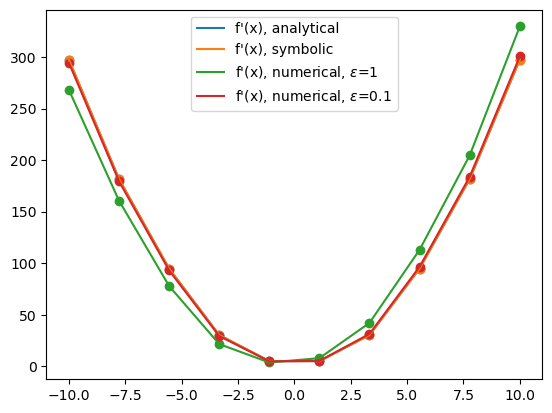

In [116]:
#myplot(x, f(x), label="f(x)")
myplot(x, anal_deriv(x), label="f'(x), analytical")
myplot(x, sympy.lambdify(x_symb,symb_deriv)(x), label="f'(x), symbolic")
epsilon=1
myplot(x, num_deriv(x, epsilon), label=f"f'(x), numerical, $\epsilon$={epsilon}")
epsilon=0.1
myplot(x, num_deriv(x, epsilon), label=f"f'(x), numerical, $\epsilon$={epsilon}")
plt.legend()

Numerical derivatives differ significatively from the exact derivatives when the step $\epsilon$ is large.
The smaller the step, the better is the numerical approximation.

However, if $\epsilon$ becomes too small...

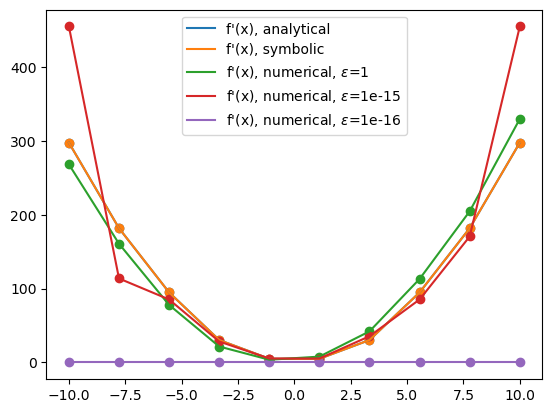

In [123]:
#myplot(x, f(x), label="f(x)")
myplot(x, anal_deriv(x), label="f'(x), analytical")
myplot(x, sympy.lambdify(x_symb,symb_deriv)(x), label="f'(x), symbolic")
epsilon=1
myplot(x, num_deriv(x, epsilon), label=f"f'(x), numerical, $\epsilon$={epsilon}")
epsilon=1e-15
myplot(x, num_deriv(x, epsilon), label=f"f'(x), numerical, $\epsilon$={epsilon}")
epsilon=1e-16
myplot(x, num_deriv(x, epsilon), label=f"f'(x), numerical, $\epsilon$={epsilon}")
plt.legend()

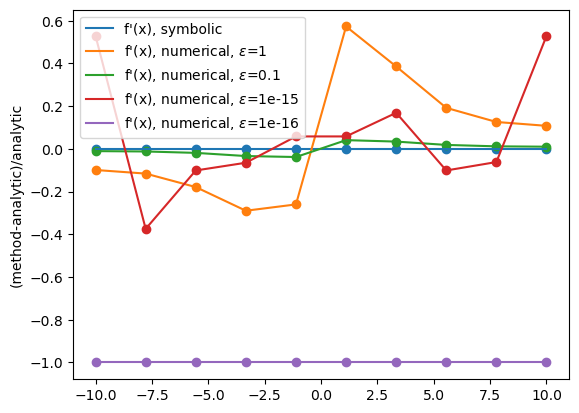

In [126]:
myplot(x, (sympy.lambdify(x_symb,symb_deriv)(x)-anal_deriv(x))/anal_deriv(x), label="f'(x), symbolic")
epsilon=1
myplot(x, (num_deriv(x, epsilon)-anal_deriv(x))/anal_deriv(x), label=f"f'(x), numerical, $\epsilon$={epsilon}")
epsilon=0.1
myplot(x, (num_deriv(x, epsilon)-anal_deriv(x))/anal_deriv(x), label=f"f'(x), numerical, $\epsilon$={epsilon}")
epsilon=1e-15
myplot(x, (num_deriv(x, epsilon)-anal_deriv(x))/anal_deriv(x), label=f"f'(x), numerical, $\epsilon$={epsilon}")
epsilon=1e-16
myplot(x, (num_deriv(x, epsilon)-anal_deriv(x))/anal_deriv(x), label=f"f'(x), numerical, $\epsilon$={epsilon}")
plt.legend()


plt.ylabel("(method-analytic)/analytic")
plt.legend()

All that remains is now to examine automatic differentiation and to see how it compares with the methods above!

We could jump directly into using one of the awesome autodiff packages that are on the market, but what would be the fun in that?

## Let's try to implement automatic differentiaton by ourselves!

### Dual numbers

We have seen that dual numbers, i.e. numbers that can be written as $a+b\epsilon$, where $\epslion^2=0$, can be used to represent a small perturbation $P(x+\epsilon)$ of a polynomial function $P(x)$. Developing the expression, we soon obtain the important result

$P(x+\epsilon) = \ldots = P(x) + \epsilon \frac{dP(x)}{dx}$.

Generalizing, we can use dual numbers to rewrite a function of a real number as a function that takes a dual number as an input, and holds the value of the function in the principal part of the dual number, and its derivative in the dual part of the dual number:

$f(a + b\epsilon) = f(a) +\epsilon f'(a)$

### Operator overloading

To use this property of dual numbers, we need a way of converting our code in such a way that each function that normally would take a `float` as an input now takes a dual number.

In python (or in C++, or in pretty much any object-oriented language) this is very easy: we can define a class that uses dual numbers arithmetic, and then we simply feed a function a dual number instead of a float.

We only have to take good care to reimplement any operator of the type class (multiplication, addition, subtraction, etc) that is present in the functions we want to feed this dual numbers to! We will also have to reimplement any accessory function like `sin(x)`, and rewrite our function to use our new implementation.

Exercise: can you figure out what to put into the missing part of the class below?
Attention: is the expression for 

In [155]:
class DualNumber:
        def __init__(self, primal, tangent=0):
                self.primal=primal
                self.tangent=tangent
        def __add__(self, other):
                return ...
        def __rmul__(self, a):
                return ...
        def __mul__(self, other):
                return ...

def dualsin(val):
        return DualNumber(...)


def f_withduals(xd):
        return 2*xd + 3*sin(xd) + xd*xd*xd

xd = DualNumber(1.,1.)
z = f_withduals(xd)

print("z =", z.primal)
print("dc/dx =", z.tangent)

TypeError: unsupported operand type(s) for +: 'ellipsis' and 'ellipsis'

Try to do it yourself!!!
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.



...but you can also simply use the full implementation below.

Note two things:
- we had to replace the floats `2`and `3` in the function with their dual counterpart. This is necessary.
- we modified the return value of the function to support array inputs and outputs. This is not necessary, we did it just to be able to then plot the autodiff derivative in the same way as we plot the other types of derivatives.

In [172]:
class DualNumber:
        def __init__(self, primal, tangent=0):
                self.primal=primal
                self.tangent=tangent
        def __add__(self, other):
                return DualNumber(  
                        self.primal+other.primal, self.tangent+other.tangent)
        def __rmul__(self, a):
                return DualNumber(
                        self.primal*a, self.tangent*a)
        def __mul__(self, other):
                return DualNumber(
                        self.primal*other.primal, self.primal*other.tangent+ self.tangent*other.primal)
def sin(val):
        return DualNumber(
                math.sin(val.primal),
                math.cos(val.primal)*val.tangent)



In [196]:
from typing import List

def f_withduals(xs):
    if isinstance(xs, List):
        return np.array( [ DualNumber(2,0) + DualNumber(3, 0)*sin(xi)+ xi*xi*xi for xi in xs] )
    else:
        return DualNumber(2,0) + DualNumber(3, 0)*sin(xs) + xs*xs*xs

print( type(np.array([1])))
xd = DualNumber(1.,1.)
z = f_withduals(xd)

print("z =", z.primal, ", to be compared with", f(1))
print("df(x)/dx =", z.tangent, ", to be compared with", anal_deriv(1))


<class 'numpy.ndarray'>
z = 5.524412954423689 , to be compared with 5.524412954423689
df(x)/dx = 4.620906917604419 , to be compared with 4.620906917604419


The autodiff derivative matches perfectly the analytical derivative.

### Automatic differentiation provides exact numerical derivatives.

Let's now see what happens if we set the derivative of the input to zero:

In [197]:
xd = DualNumber(1.,0)
z = f_withduals(xd)

print("z =", z.primal, ", to be compared with", f(1))
print("df(x)/dx =", z.tangent, ", to be compared with", anal_deriv(1))


z = 5.524412954423689 , to be compared with 5.524412954423689
df(x)/dx = 0.0 , to be compared with 4.620906917604419


In automatic differentiation, for derivatives to be propagated correctly we must provide an input derivative of $1$, corresponding to the first differentiation in the chain rule, i.e. the derivative of the input with respect to itself).

We are now ready to compare our autodiff derivative with the other derivatives we used above.

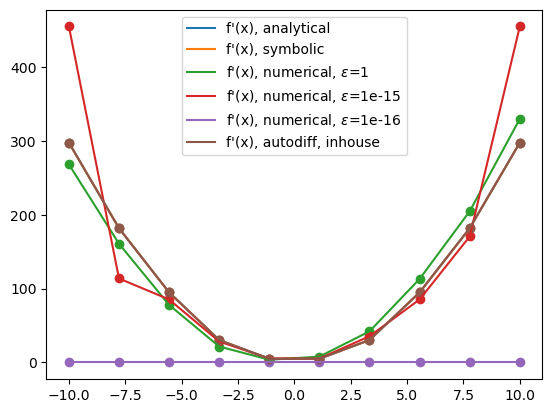

In [199]:
x_dual = [ DualNumber(xi, 1.) for xi in x ]
#myplot(x, f(x), label="f(x)")
myplot(x, anal_deriv(x), label="f'(x), analytical")
myplot(x, sympy.lambdify(x_symb,symb_deriv)(x), label="f'(x), symbolic")
epsilon=1
myplot(x, num_deriv(x, epsilon), label=f"f'(x), numerical, $\epsilon$={epsilon}")
epsilon=1e-15
myplot(x, num_deriv(x, epsilon), label=f"f'(x), numerical, $\epsilon$={epsilon}")
epsilon=1e-16
myplot(x, num_deriv(x, epsilon), label=f"f'(x), numerical, $\epsilon$={epsilon}")
myplot(x, [xi.tangent for xi in f_withduals(x_dual)], label="f'(x), autodiff, inhouse")

plt.legend()

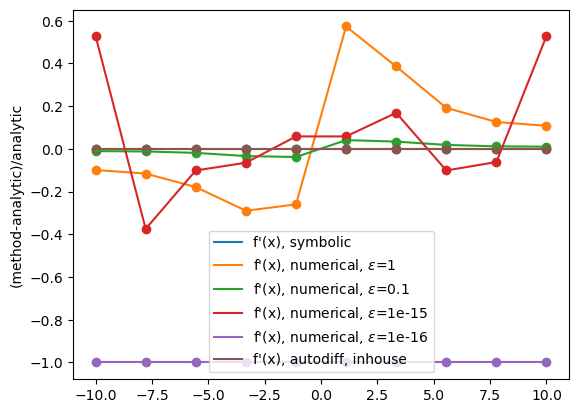

In [200]:
myplot(x, (sympy.lambdify(x_symb,symb_deriv)(x)-anal_deriv(x))/anal_deriv(x), label="f'(x), symbolic")
epsilon=1
myplot(x, (num_deriv(x, epsilon)-anal_deriv(x))/anal_deriv(x), label=f"f'(x), numerical, $\epsilon$={epsilon}")
epsilon=0.1
myplot(x, (num_deriv(x, epsilon)-anal_deriv(x))/anal_deriv(x), label=f"f'(x), numerical, $\epsilon$={epsilon}")
epsilon=1e-15
myplot(x, (num_deriv(x, epsilon)-anal_deriv(x))/anal_deriv(x), label=f"f'(x), numerical, $\epsilon$={epsilon}")
epsilon=1e-16
myplot(x, (num_deriv(x, epsilon)-anal_deriv(x))/anal_deriv(x), label=f"f'(x), numerical, $\epsilon$={epsilon}")
myplot(x, ([xi.tangent for xi in f_withduals(x_dual)]-anal_deriv(x))/anal_deriv(x), label="f'(x), autodiff, inhouse")
plt.legend()


plt.ylabel("(method-analytic)/analytic")
plt.legend()

OK, so automatic differentiation is cool, it works, and it is fast!!!

It is now time to take a look at automatic differentiation in one of the most popular autodiff frameworks, `torch`.

`Torch` is a library for tensor calculus developed mainly for machine learning purposes. You may recall from the lecture that most of modern machine learning based on perceptrons consists essentially in products of arbitrarily dimensioned matrices, i.e. **tensors**

In [201]:
import torch

In [210]:
xt = torch.tensor(x, requires_grad=False)

f_torch = 2 + 3*torch.sin(xt)+ xt**3

With torch, we can also examine first-hand the concept of Wengert list (computational graph) that we have discussed during the lecture!

The package `torchviz` provides an easy way of printing the computational graph of any expression

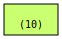

In [211]:
!pip install torchviz
from torchviz import make_dot
make_dot(xt)


The tensor `xt` is indeed a simple tensor.

What about the function?

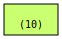

In [212]:
make_dot(f_torch)

There is something going on. The function should not have the same computational graph as its input tensor.

Let's forget this for a moment, and try to compute the derivatives: in `torch`, the directive that tells the package to propagate derivatives via automatic differentiation is `backward`.

In [213]:
f_torch.backward(torch.ones_like(f_torch))
print(xt.grad)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

Weird! Why can't the software calculate derivatives? Well, it seems that `xt` "does not require gradients".

That's because when we defined it we havent requested `pytorch` to keep track of gradients for this tensor!

`Torch` will track only gradients of objects we explicitly require the gradients of, to avoid spending memory and computation time unnecessarily tracking gradients for objects we may not need to differentiate through.

This is what in the lecture we called the `define-and-run` method for building dynamical graphs (as opposed by the `define-and-run` paradigma used e.g. by `tensorflow` to build static graphs)

In [216]:
xt = torch.tensor(x, requires_grad=True)

f_torch = 2 + 3*torch.sin(xt)+ xt**3

In [217]:
f_torch.backward(torch.ones_like(f_torch))
print(xt.grad)

tensor([297.4828, 181.7099,  94.8329,  30.3883,   5.0347,   5.0347,  30.3883,
         94.8329, 181.7099, 297.4828], dtype=torch.float64)


Now gradients got calculated!

Let's take a look again at the computational graphs:

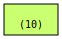

In [218]:
make_dot(xt)

But now, when we plot the computational graph of `f_torch`...

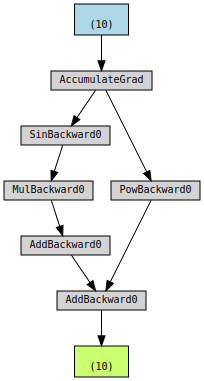

In [219]:
make_dot(f_torch)

Now that we have told torch that we will need to differentiate through `xt`, torch will enable the computational graph calculation for any function that makes use of `xt`.

This is the Wengert list of the function, a Directed Acyclyc Graph of atomic operations.

Note that the names of the functions highlight the fact that each of them (`Add`, `Pow`, etc) is actually present in its "let's track gradients" version (`AddBackward`, `PowBackward`, etc)

We are now ready to compare the `torch` autodiff with our inhouse autodiff!

In order for the plot to not be too crowded, let's just compare the two autodiff implementations with each other and with the analytical solution.

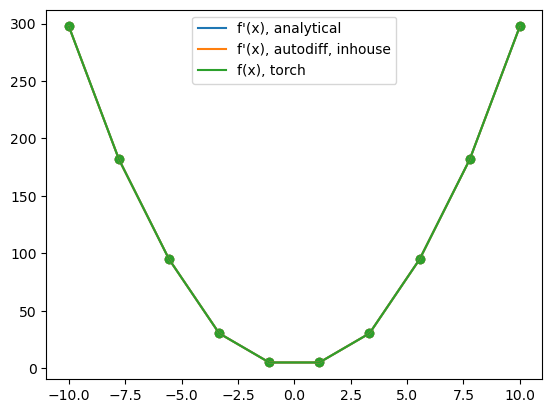

In [220]:
x_dual = [ DualNumber(xi, 1.) for xi in x ]
#myplot(x, f(x), label="f(x)")
myplot(x, anal_deriv(x), label="f'(x), analytical")
#myplot(x, sympy.lambdify(x_symb,symb_deriv)(x), label="f'(x), symbolic")
#epsilon=1
#myplot(x, num_deriv(x, epsilon), label=f"f'(x), numerical, $\epsilon$={epsilon}")
#epsilon=1e-15
#myplot(x, num_deriv(x, epsilon), label=f"f'(x), numerical, $\epsilon$={epsilon}")
#epsilon=1e-16
#myplot(x, num_deriv(x, epsilon), label=f"f'(x), numerical, $\epsilon$={epsilon}")
myplot(x, [xi.tangent for xi in f_withduals(x_dual)], label="f'(x), autodiff, inhouse")
myplot(xt.detach().numpy(), xt.grad.detach().numpy(), label="f(x), torch")

plt.legend()

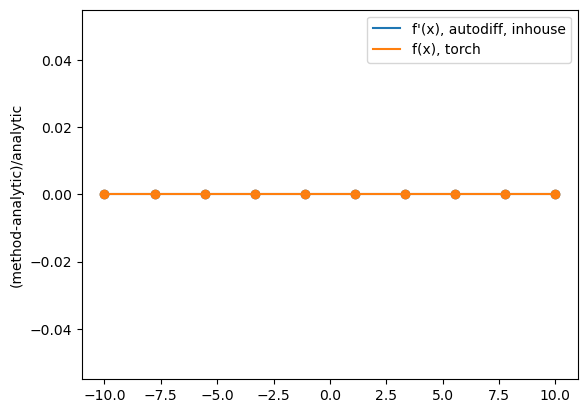

In [221]:
myplot(x, ([xi.tangent for xi in f_withduals(x_dual)]-anal_deriv(x))/anal_deriv(x), label="f'(x), autodiff, inhouse")
myplot(xt.detach().numpy(), (xt.grad.detach().numpy()-anal_deriv(x))/anal_deriv(x), label="f(x), torch")

plt.legend()


plt.ylabel("(method-analytic)/analytic")
plt.legend()

Wow!!!

Our autodiff implementation is as good as any other one, for these simple examples!

Autodiff is really simple: packages like `torch` just add a lot of bells and whistles:
- almost any function implemented in a way that supports autodiff
- support for tensor operations
- support for parallelization on CPUs and GPUs
- ...

## Functions of many variables

Now, let's go back to our implementation, and write down a function that takes two inputs.

We will use the function that we have seen during the lecture


<img src="autodiff_example.png" alt="drawing" width="50%"/>

Image by [me](https://www.hep.uniovi.es/vischia/persistent/2024-10-04_DifferentiableProgrammingForTheFrontiersOfComputationAt2ndCOMCHAWorkshop_vischia.html)


The function is

$f(x_0, x_1) = 2x_0 + x_0\cdot sin(x_1) + x_1^3$

The initial values we used for the two variables are:

$x_0 = 1$

$x_1 = 2$

And for these values we expect that:

$f(x_0, x_1) = 10.9093$

$f'_{x0} = 2.9093$

$f'_{x0} = 11.5839$

(where $f'_{x0} := \frac{\partial d f(x_0, x_1)}{d x_0} |_{x_0=1, x_1=2}$

In [226]:
def func(x,y):
        return 2*x + x*sin(y) + y*y*y
x = DualNumber(1., 1.)
y = DualNumber(2.)
z = func(x, y)
print("z =", z.primal)
print("df(x, y)/dx =", z.tangent)

z = 10.909297426825681
df(x, y)/dx = 2.909297426825682


Remarkably, this differentiation gives as an output the derivatives with respect to only one of the inputs.
In order to obtain the derivative with respect to the other input, we will have to set the nonzero derivative for the other input:

In [228]:
x = DualNumber(1.)
y = DualNumber(2., 1.)
z = func(x, y)
print("z =", z.primal)
print("df(x, y)/dx =", z.tangent)

z = 10.909297426825681
df(x, y)/dx = 11.583853163452858


This means our autodiff implementation based on dual numbers is a case of **forward mode automatic differentiation**.

To obtain the derivatives with respect to all inputs, we have to go through the forward mode once per each dimension of the input!

This is not handy for functions that map a larger-dimensional space into a smaller-dimensional space, such as our function

$f: \mathbb{R}^2->\mathbb{R}$

The most common libraries on the market implement both the forward and backward mode of automatic differentiation.

Let's examine the backward mode using pytorch:

In [259]:
x0 = torch.tensor(1., requires_grad=True)
x1 = torch.tensor(2., requires_grad=True)
f = 2*x0 + x0*math.sin(x1) + x1**3
print(f)
f.backward()
print(x0.grad, x1.grad)

tensor(10.9093, grad_fn=<AddBackward0>)
tensor(2.9093) tensor(12.)


Torch has calculated both derivatives at the same time: it is using the **backward** mode of automatic differentiation, which is very handy to map higher-dimensional spaces into lower-dimensional spaces (i.e. most of modern machine learning).

However, **the derivative with respect to $x_1$ is wrong!!!**

We expected (from our autodiff and from the analytical calculation) $11.5839$, but we got $12$!!!

Can you figure out what is going on?

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.



I used some sleight of hand and wrote the function as

`f = 2*x0 + x0*math.sin(x1) + x1**3`

This expression uses the `sin` function from the `math` library. From the point of view of torch, `math.sin` is an expression *for which automatic differentiation is not supported*!!!

Let's confirm that by looking at the computational graph: do you spot any mention to the `sin` function?

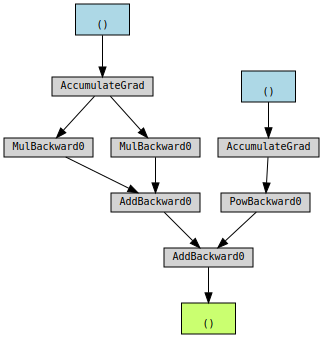

In [260]:
make_dot(f)

Let's now redefine the function to use `torch.sin`:

In [268]:
x0 = torch.tensor(1., requires_grad=True)
x1 = torch.tensor(2., requires_grad=True)
f = 2*x0 + x0*torch.sin(x1) + x1**3
print(f)
f.backward()
print(x0.grad, x1.grad)

tensor(10.9093, grad_fn=<AddBackward0>)
tensor(2.9093) tensor(11.5839)


Now the gradients are the correct ones!!!

Sadly, torch doesn't warn us when we use non-torch functions for which autodiff is not supported, so it is crucial to stay alert when writing your code, otherwise any downstream result will be egregiously wrong!

Let's confirm all of this by looking at the computational graph: can you spot the autodiff-supported version of `sin` (`SinBackward`), now?

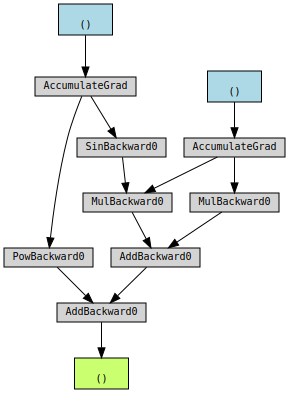

In [257]:
make_dot(ft)

Let's also notice two important peculiarities of automatic differentiation.

Let's propagate the gradients again, without redefining the function:

In [266]:

print(f)
f.backward()
print(x0.grad, x1.grad)

tensor(10.9093, grad_fn=<AddBackward0>)


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

Torch correctly warns us that we had already propagated gradients through $f(x_0, x_1)$ once.

Let's then recreate the function, and run backwards again:

In [274]:
f= 2*x0 + x0*torch.sin(x1) + x1**3
print(f)
f.backward()
print(x0.grad, x1.grad)

tensor(10.9093, grad_fn=<AddBackward0>)
tensor(5.8186) tensor(23.1677)


What is happening???

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

The gradients are associated to the tensors $x0$ and $x1$, and are therefore not reset. When we redefine the function, we create a new computational graph (and can therefore call `.backward()` on it), but we haven't reset the gradients of the input tensors, so torch will just sum the new gradients to the old ones. You can cross check that the new gradients are a multiplier of the original ones.

If we want the proper derivatives without accumulation, we need to recreate the input tensors.

Incidentally, this automatic accumulation of gradients is designed on purpose, in `torch`, in order to make backpropagation in neural networks (where with batch or minibatch gradient descent the gradients are accumulated before each step, as we will see tomorrow) very efficiently handy.

In [276]:
x0 = torch.tensor(1., requires_grad=True)
x1 = torch.tensor(2., requires_grad=True)
f= 2*x0 + x0*torch.sin(x1) + x1**3
print(f)
f.backward()
print(x0.grad, x1.grad)

tensor(10.9093, grad_fn=<AddBackward0>)
tensor(2.9093) tensor(11.5839)


# The end!!!

## (for today)